In [48]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')

# Au Lecteur

This notebook is a playground for experimenting with various machine learning algorithms 

![](https://media.giphy.com/media/zx6Tsme145Eoo/giphy.gif)

# UCI Wine Quality Investigation

### Preliminary Inspection

In [149]:
# wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delimiter=';')
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=';')

In [150]:
for col in enumerate(zip(wine.columns, wine.dtypes)):
    print(col)

(0, ('fixed acidity', dtype('float64')))
(1, ('volatile acidity', dtype('float64')))
(2, ('citric acid', dtype('float64')))
(3, ('residual sugar', dtype('float64')))
(4, ('chlorides', dtype('float64')))
(5, ('free sulfur dioxide', dtype('float64')))
(6, ('total sulfur dioxide', dtype('float64')))
(7, ('density', dtype('float64')))
(8, ('pH', dtype('float64')))
(9, ('sulphates', dtype('float64')))
(10, ('alcohol', dtype('float64')))
(11, ('quality', dtype('int64')))


In [10]:
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Null Treatment

In [152]:
# Dopeness.
print(pd.isnull(wine).apply(sum))

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


### Exploratory Plots

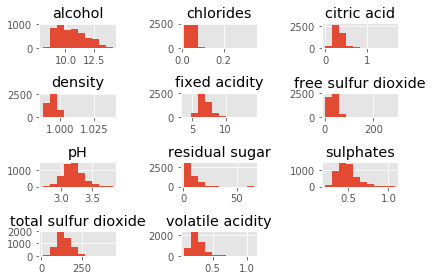

In [151]:
wine.drop('quality', axis=1).hist()
plt.tight_layout()

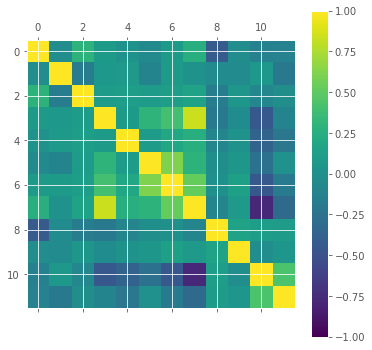

In [153]:
corrs = wine.corr()

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(corrs, vmin=-1, vmax=1)
fig.colorbar(cax)

### Feature Importance

In [154]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(wine.values[:, 0:10], wine['quality'])
print(list(zip(wine.columns, etc.feature_importances_)))

[('fixed acidity', 0.086472447630251553), ('volatile acidity', 0.10760342752346856), ('citric acid', 0.096747659008217912), ('residual sugar', 0.098602619836012234), ('chlorides', 0.093998305293912898), ('free sulfur dioxide', 0.099147414832619921), ('total sulfur dioxide', 0.10160254265112831), ('density', 0.12453466205948553), ('pH', 0.097197059531946337), ('sulphates', 0.094093861632956619)]


In [171]:
from operator import itemgetter

importances = list(zip(wine.columns, etc.feature_importances_))
importances.sort(key=itemgetter(1), reverse=True)

for i, pair in enumerate(importances, start=1):
    print('{}. {} ({})'.format(i, *pair))

1. density (0.12453466205948553)
2. volatile acidity (0.10760342752346856)
3. total sulfur dioxide (0.10160254265112831)
4. free sulfur dioxide (0.09914741483261992)
5. residual sugar (0.09860261983601223)
6. pH (0.09719705953194634)
7. citric acid (0.09674765900821791)
8. sulphates (0.09409386163295662)
9. chlorides (0.0939983052939129)
10. fixed acidity (0.08647244763025155)


In [172]:
# Let's look at the importance distribution?...
importances = pd.Series(etc.feature_importances_)

In [173]:
importances.describe()

count    10.000000
mean      0.100000
std       0.010205
min       0.086472
25%       0.094757
50%       0.097900
75%       0.100989
max       0.124535
dtype: float64

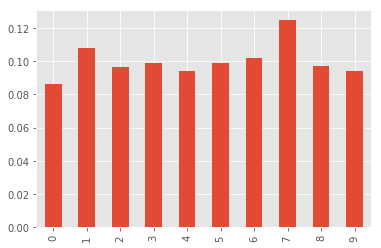

In [174]:
importances.plot(kind='bar')

## Modeling

### Preprocessing

In [175]:
from sklearn.model_selection import train_test_split

raw = wine.values
X = raw[:, 0:10]
y = raw[:, 11]

print(X.shape, y.shape)

(4898, 10) (4898,)


In [176]:
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state=1)

### Model Selection & Training

In [177]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC

kfold = KFold(n_splits=10, random_state=1)
models = [('LR', LinearRegression()), ('Ridge', Ridge()), ('Lasso', Lasso()), ('EN', ElasticNet()), ('kNN', KNeighborsRegressor()), ('SVC', SVC())]

In [178]:
results = []
for model in [m[1] for m in models]:
    results.append(cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error'))

In [188]:
for result in results:
    print(result.mean())

0.244185952994
0.24421156664
-0.0224618241296
-0.0224618241296
0.194515872649
0.541671883477


### Take 2: Standardize Input

In [180]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)

In [181]:
X_r = scaler.transform(X)

#### Intermezzo: Fun w/ Violins

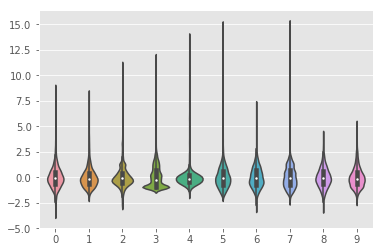

In [182]:
# N.b., y units are meaningless due to rescaling, but relative distributions are preserved 
sns.violinplot(data=X_r)

In [192]:
# TODO: Some other stuff

KeyboardInterrupt: 